In [1]:
import os
import glob
import numpy as np
import pandas as pd

In [2]:
def load(test_output_dir, test):
    dfs = {}
    times = {}

    for dir in glob.glob(os.path.join(test_output_dir, test, '*')):
        _, specific = os.path.split(dir)
        specific = specific.split(test + '_')[1]

        csvs = glob.glob(os.path.join(dir, '*.csv'))
        dfs[specific] = [pd.read_csv(csv, index_col=0) for csv in csvs]

        with open(os.path.join(dir, 'time.txt'), 'r') as f:
            time = float(f.readlines()[0])
        times[specific] = time

    for k in dfs.keys():
        print(k)

    return dfs, times

def plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs):
    anchor = dfs[anchor_name][0]
    comparisons = [dfs[n][0] for n in comparison_names]

    labels = [anchor_name] + comparison_names

    ax = anchor[species].plot.hist(**kwargs)

    for c in comparisons:
        c[species].plot.hist(ax=ax, **kwargs)

    ax.legend(labels)

In [3]:
# Cai and Petzold used K=50 for N=1,000,000 in the paper, but K probably should be chosen in reference to the size of the range?
# Probably worth experimenting with a range of Ks (it is super cheap to do so)

def histogram_distance(s1, s2, K):
    # a binned version of so-called "density distance"
    xmax = max(s1.max(), s2.max())
    xmin = min(s1.min(), s2.min())

    I = np.linspace(xmin, xmax, K)

    hist1, _ = np.histogram(s1, I)
    hist2, _ = np.histogram(s2, I)

    return np.sum(np.abs(hist1/len(s1) - hist2/len(s2)))

def self_distance(N, K):
    return np.sqrt(4*K / (np.pi * N))

def kolmogorov_distance(s1, s2):
    pass

def kolmogorov_self_distance(N):
    return np.log(2) * np.sqrt(np.pi/N)

## Decaying isomerization

In [15]:
test_output_dir = './cluster_output_june_28/'
test = 'decaying_isomerization'

dfs, _ = load(test_output_dir, test)

less_stiff_short_tau_01
ss_least_stiff_shortest_initial_ss_ss
less_stiff_short_hybrid
stiff_long_hybrid
ss_less_stiff_short_initial_ss_hybrid
stiff_long_implicit_tau_01
least_stiff_shortest_hybrid_cle
ss_stiff_long_initial_ss_ss
least_stiff_shortest_tau_01
less_stiff_short_implicit_tau_01
least_stiff_shortest_implicit_tau_01
least_stiff_shortest_hybrid
less_stiff_short_hybrid_cle


In [19]:
anchor_name = 'least_stiff_shortest_gillespie'

comparison_names = [
    #'ss_least_stiff_shortest_initial_ss_ss'
    'least_stiff_shortest_hybrid',
    'least_stiff_shortest_hybrid_cle',
    #'least_stiff_shortest_tau_10',
]

species = 'S3'

In [20]:
kwargs = {
    'density': True,
    #'bins': 15,
    'alpha': 0.5,
}

plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs)

KeyError: 'least_stiff_shortest_gillespie'

## Schlogl

In [22]:
test_output_dir = './cluster_output_june_28/'
test = 'schlogl'

dfs, times = load(test_output_dir, test)

gillespie_df = dfs['gillespie'][0]['X']
K = 100

tau_30
tau_01
tau_005
hybrid_cle
tau_40
hybrid
tau_05
tau_50
tau_10
gillespie
tau_20


In [23]:
errors = {}
for k in dfs.keys():
    print(k)
    errors[k] = histogram_distance(gillespie_df, dfs[k][0]['X'], K)
errors

tau_30
tau_01
tau_005
hybrid_cle
tau_40
hybrid
tau_05
tau_50
tau_10
gillespie
tau_20


{'tau_30': 0.19279999999999997,
 'tau_01': 0.08999999999999998,
 'tau_005': 0.08960000000000001,
 'hybrid_cle': 0.09819999999999998,
 'tau_40': 0.293,
 'hybrid': 1.9952,
 'tau_05': 0.0956,
 'tau_50': 0.40559999999999996,
 'tau_10': 0.0874,
 'gillespie': 0.0,
 'tau_20': 0.1232}

In [24]:
anchor_name = 'gillespie'

comparison_names = [
    'tau_01',
    'hybrid_cle'
]

species = 'X'

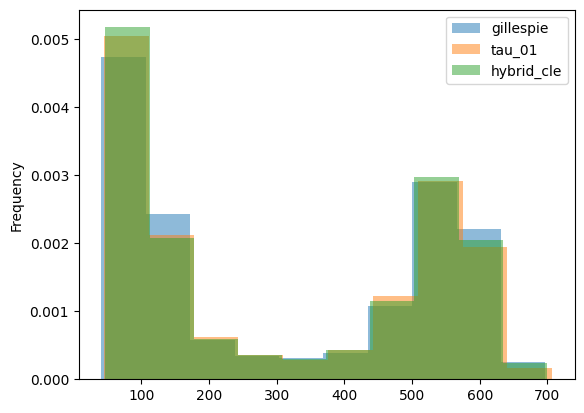

In [25]:
plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs)

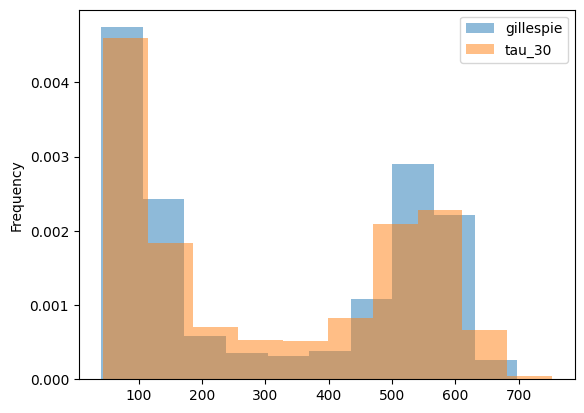

In [26]:
plot_comparisons(species, dfs, anchor_name, ['tau_30'], **kwargs)

In [27]:
epsilons = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
taus = ['tau_005', 'tau_01', 'tau_05', 'tau_10', 'tau_20', 'tau_30', 'tau_40', 'tau_50']
taus = [dfs[n][0]['X'] for n in taus]

cle = dfs['hybrid_cle'][0]['X']

In [28]:
histogram_distances = [histogram_distance(gillespie_df, t, K) for t in taus]

In [29]:
histogram_distance(gillespie_df, cle, K)

0.09819999999999998

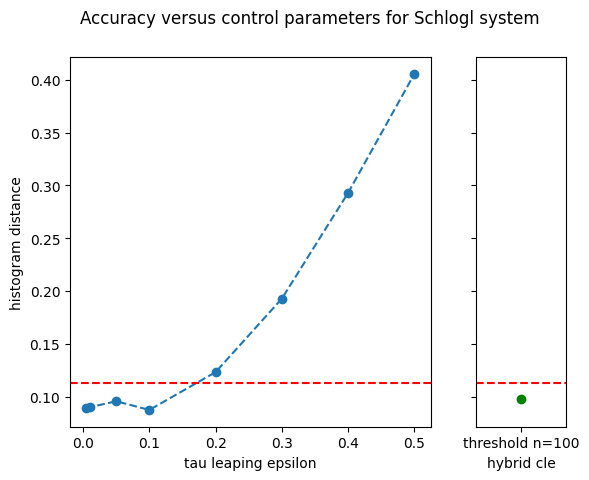

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, width_ratios=[4, 1], sharey=True)

ax[0].set_ylabel('histogram distance')

ax[0].scatter(epsilons, histogram_distances)
ax[0].plot(epsilons, histogram_distances, linestyle='--')

ax[0].axhline(self_distance(len(gillespie_df), K), c='r', linestyle='--')
ax[1].axhline(self_distance(len(gillespie_df), K), c='r', linestyle='--')

ax[0].set_xlabel('tau leaping epsilon')

ax[1].scatter(['threshold n=100'], [histogram_distance(gillespie_df, cle, K)], c='g')
ax[1].set_xlabel('hybrid cle')

plt.suptitle('Accuracy versus control parameters for Schlogl system')
plt.savefig('accuracy_vs_control.png', dpi=300)

In [64]:
error_df = pd.DataFrame({k:[errors[k], times[k]] for k in errors.keys()}).T
error_df.columns = ['histogram distance', 'time']
error_df.drop(['hybrid', 'gillespie'], inplace=True)
error_df['type'] = 'tau'
#error_df[error_df['']]['color']
# where is a little confusing: keeps the value where true
error_df['type'] = error_df['type'].where(error_df.index.str.contains('tau'), 'hybrid cle')

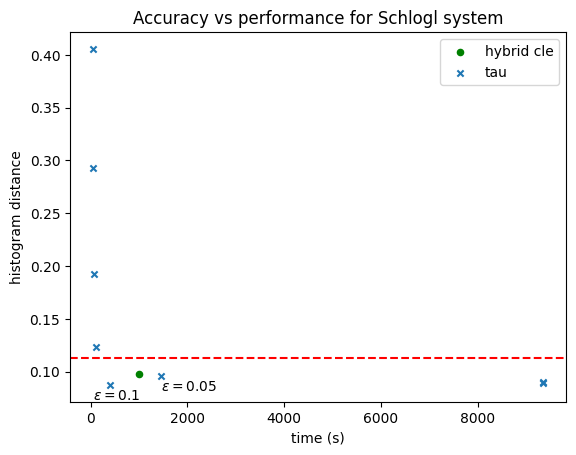

In [65]:
fig, ax = plt.subplots(1, 1)

markers = ['o', 'x']
colors = ['g', None]
i = 0
for k,g in error_df.groupby('type'):
    g.plot.scatter(ax=ax, x='time', y='histogram distance', marker=markers[i], color=colors[i], label=k)
    i += 1

#ax = error_df.plot.scatter(x='time', y='histogram distance', marker='x', c=error_df['color'], label='foo')

ax.axhline(self_distance(len(gillespie_df), K), c='r', linestyle='--')
plt.title('Accuracy vs performance for Schlogl system')
plt.xlabel('time (s)')

ax.annotate('$\\epsilon = 0.1$', (error_df.loc['tau_10']['time'] - 350, error_df.loc['tau_10']['histogram distance'] - 0.014))
ax.annotate('$\\epsilon = 0.05$', (error_df.loc['tau_05']['time'], error_df.loc['tau_05']['histogram distance'] - 0.014))

plt.savefig('accuracy_vs_performance.png', dpi=300)

In [38]:
error_df

,histogram distance,time,type
tau_30,0.1928,61.678826,tau
tau_01,0.0900,9357.602091,tau
tau_005,0.0896,9343.264316,tau
hybrid_cle,0.0982,1002.961782,hybrid
tau_40,0.2930,56.632169,tau
tau_05,0.0956,1462.830790,tau
tau_50,0.4056,38.525951,tau
tau_10,0.0874,403.111664,tau
tau_20,0.1232,110.174002,tau
